## Conv1D

### Todos

* Somehow add multiple rides
* Checkpoints

In [226]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

# add src to sys-path
import sys
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sys.path.append('../src')

from data_processing.mtb_data_provider import MtbDataProvider
from visualization.visualize import MtbVisualizer
from models.conv1d_model import Conv1dModel
from models.conv2d_model import Conv2dModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.41 ms


In [5]:
WINDOW_SIZE = 16000
FREQUENCY = 80
SAMPLE_SIZE = WINDOW_SIZE // FREQUENCY

time: 809 µs


### Prepare data

#### Conv1D, 1 Sensor

In [ ]:
RAW_FILE = 'mytrainsession'
VAL_FILE = 'mydevsession'

In [232]:
X_train, y_train = MtbDataProvider.load_data('../data/raw/' + RAW_FILE, '_1.csv', frequency=FREQUENCY)
X_train, y_train = MtbDataProvider.slice_single_sensor(X_train, y_train, window_size=WINDOW_SIZE, frequency=FREQUENCY)
X_train.shape

['../data/raw/mytrainsession_1.csv'] ../data/raw/mytrainsession_labels.csv


(41, 200, 3)

time: 26 ms


In [233]:
X_dev, y_dev = MtbDataProvider.load_data('../data/raw/' + VAL_FILE, '_1.csv', frequency=FREQUENCY)
X_dev, y_dev = MtbDataProvider.slice_single_sensor(X_dev, y_dev, window_size=WINDOW_SIZE, frequency=FREQUENCY)

['../data/raw/mydevsession_1.csv'] ../data/raw/mydevsession_labels.csv
time: 16 ms


#### Conv2d, multiple Sensors and multiple sessions

In [292]:
RAW_FILES = ['mytrainsession', 'anothersession'] # Multiple Sessions
VAL_FILE = 'mydevsession'

time: 818 µs


In [294]:
"""
This loads all files, named in RAW_FILES and concatenates the final slices
TODO: This should maybe go into the DataProvider as well
"""
X_train = None
y_train = None
for raw_file in RAW_FILES:
    X, y = MtbDataProvider.load_data('../data/raw/' + raw_file, '*?[0-9].csv', frequency=FREQUENCY) # Multiple Sensors
    X = MtbDataProvider.sync_sensors(X)
    X, y = MtbDataProvider.slice_multiple_sensors(X, y, window_size=WINDOW_SIZE, frequency=FREQUENCY)
    
    if X_train is None:
        X_train = X
        y_train = y
    else:
        X_train = np.concatenate((X_train, X))
        y_train = np.concatenate((y_train, y))

X_train.shape

['../data/raw/mytrainsession_1.csv', '../data/raw/mytrainsession_2.csv'] ../data/raw/mytrainsession_labels.csv
['../data/raw/anothersession_1.csv', '../data/raw/anothersession_2.csv'] ../data/raw/anothersession_labels.csv


(59, 200, 2, 3)

time: 141 ms


In [295]:
X_dev, y_dev = MtbDataProvider.load_data('../data/raw/' + VAL_FILE, '*?[0-9].csv', frequency=FREQUENCY)
X_dev = MtbDataProvider.sync_sensors(X_dev)

X_dev, y_dev = MtbDataProvider.slice_multiple_sensors(X_dev, y_dev, window_size=WINDOW_SIZE, frequency=FREQUENCY)
X_dev.shape

['../data/raw/anothersession_1.csv', '../data/raw/anothersession_2.csv'] ../data/raw/anothersession_labels.csv


(18, 200, 2, 3)

time: 56.1 ms


## Evaluation

### Conv1D, 1 Sensor

In [ ]:
model_cnn1 = Conv1dModel.build_model(input_shape=X_train[0].shape)

In [ ]:
model_cnn1.summary()

In [ ]:
model_cnn1.fit(X_train, y_train,
              epochs=1000,
              batch_size=32,
              validation_data=(X_dev, y_dev))

### Conv2D, Multiple Sensors

In [272]:
model_cnn2 = Conv2dModel.build_model(input_shape=X_train[0].shape, kernel_size=(5, X_train.shape[2]))

time: 308 ms


In [273]:
model_cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 200, 2, 3)         93        
_________________________________________________________________
batch_normalization_19 (Batc (None, 200, 2, 3)         12        
_________________________________________________________________
activation_19 (Activation)   (None, 200, 2, 3)         0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 200, 2, 3)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 200, 2, 3)         93        
_________________________________________________________________
batch_normalization_20 (Batc (None, 200, 2, 3)         12        
_________________________________________________________________
activation_20 (Activation)   (None, 200, 2, 3)         0         
__________

In [296]:
model_cnn2.fit(X_train, y_train,
              epochs=1000,
              batch_size=32,
              validation_data=(X_dev, y_dev))

Train on 59 samples, validate on 18 samples
Epoch 1/1000
59/59 [==============================] - 0s 741us/step - loss: 4.9452 - sparse_categorical_accuracy: 0.6271 - val_loss: 16.1181 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/1000
59/59 [==============================] - 0s 725us/step - loss: 2.8249 - sparse_categorical_accuracy: 0.7119 - val_loss: 2.6459 - val_sparse_categorical_accuracy: 0.6667
Epoch 3/1000
59/59 [==============================] - 0s 767us/step - loss: 1.3793 - sparse_categorical_accuracy: 0.3220 - val_loss: 4.3510 - val_sparse_categorical_accuracy: 0.6667
Epoch 4/1000
59/59 [==============================] - 0s 752us/step - loss: 0.4583 - sparse_categorical_accuracy: 0.8305 - val_loss: 0.2344 - val_sparse_categorical_accuracy: 0.9444
Epoch 5/1000
59/59 [==============================] - 0s 752us/step - loss: 0.2568 - sparse_categorical_accuracy: 0.9153 - val_loss: 2.2205 - val_sparse_categorical_accuracy: 0.3333
Epoch 6/1000
59/59 [=====================

59/59 [==============================] - 0s 682us/step - loss: 5.6711e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0043 - val_sparse_categorical_accuracy: 1.0000
Epoch 46/1000
59/59 [==============================] - 0s 707us/step - loss: 0.0021 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0037 - val_sparse_categorical_accuracy: 1.0000
Epoch 47/1000
59/59 [==============================] - 0s 738us/step - loss: 2.0222e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0031 - val_sparse_categorical_accuracy: 1.0000
Epoch 48/1000
59/59 [==============================] - 0s 723us/step - loss: 2.5030e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0026 - val_sparse_categorical_accuracy: 1.0000
Epoch 49/1000
59/59 [==============================] - 0s 721us/step - loss: 1.6995e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0022 - val_sparse_categorical_accuracy: 1.0000
Epoch 50/1000
59/59 [==============================] - 0s 703us/step - loss: 1.9383

59/59 [==============================] - 0s 688us/step - loss: 3.3793e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1005e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 89/1000
59/59 [==============================] - 0s 675us/step - loss: 2.8837e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.9810e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 90/1000
59/59 [==============================] - 0s 734us/step - loss: 4.5966e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.0936e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 91/1000
59/59 [==============================] - 0s 742us/step - loss: 2.6131e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 8.3868e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 92/1000
59/59 [==============================] - 0s 730us/step - loss: 1.2218e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 7.7137e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 93/1000
59/59 [==============================] - 0s 7

Epoch 131/1000
59/59 [==============================] - 0s 657us/step - loss: 5.5556e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.2635e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 132/1000
59/59 [==============================] - 0s 692us/step - loss: 1.0377e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.2264e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 133/1000
59/59 [==============================] - 0s 700us/step - loss: 7.2258e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.2184e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 134/1000
59/59 [==============================] - 0s 693us/step - loss: 2.6549e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.1714e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 135/1000
59/59 [==============================] - 0s 708us/step - loss: 0.0023 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.2409e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 136/1000
59/59 [======================

Epoch 174/1000
59/59 [==============================] - 0s 666us/step - loss: 6.5163e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.8880e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 175/1000
59/59 [==============================] - 0s 685us/step - loss: 6.9772e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.0409e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 176/1000
59/59 [==============================] - 0s 683us/step - loss: 4.8290e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.0681e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 177/1000
59/59 [==============================] - 0s 678us/step - loss: 8.1540e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.0687e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 178/1000
59/59 [==============================] - 0s 677us/step - loss: 3.6903e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.0668e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 179/1000
59/59 [==================

Epoch 217/1000
59/59 [==============================] - 0s 712us/step - loss: 3.8694e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 7.9405e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 218/1000
59/59 [==============================] - 0s 688us/step - loss: 4.6720e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 7.7815e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 219/1000
59/59 [==============================] - 0s 682us/step - loss: 5.3459e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 7.5895e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 220/1000
59/59 [==============================] - 0s 701us/step - loss: 9.3090e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 7.4835e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 221/1000
59/59 [==============================] - 0s 719us/step - loss: 4.8875e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 7.3908e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 222/1000
59/59 [==================

Epoch 260/1000
59/59 [==============================] - 0s 689us/step - loss: 3.7542e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.3577e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 261/1000
59/59 [==============================] - 0s 674us/step - loss: 3.8813e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.4968e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 262/1000
59/59 [==============================] - 0s 679us/step - loss: 5.5223e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.4372e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 263/1000
59/59 [==============================] - 0s 697us/step - loss: 7.9055e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.4372e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 264/1000
59/59 [==============================] - 0s 692us/step - loss: 7.1925e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.4239e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 265/1000
59/59 [==================

Epoch 303/1000
59/59 [==============================] - 0s 690us/step - loss: 4.3392e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.7021e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 304/1000
59/59 [==============================] - 0s 702us/step - loss: 7.3274e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.6160e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 305/1000
59/59 [==============================] - 0s 676us/step - loss: 3.5951e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.5233e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 306/1000
59/59 [==============================] - 0s 679us/step - loss: 2.6142e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.4703e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 307/1000
59/59 [==============================] - 0s 676us/step - loss: 8.4221e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.5167e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 308/1000
59/59 [==================

Epoch 346/1000
59/59 [==============================] - 0s 710us/step - loss: 6.7458e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.2319e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 347/1000
59/59 [==============================] - 0s 720us/step - loss: 2.5200e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.1855e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 348/1000
59/59 [==============================] - 0s 740us/step - loss: 6.2998e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.1988e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 349/1000
59/59 [==============================] - 0s 653us/step - loss: 2.3020e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.1789e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 350/1000
59/59 [==============================] - 0s 658us/step - loss: 9.4878e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.1590e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 351/1000
59/59 [==================

Epoch 389/1000
59/59 [==============================] - 0s 743us/step - loss: 8.5413e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.8610e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 390/1000
59/59 [==============================] - 0s 748us/step - loss: 4.4323e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.9008e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 391/1000
59/59 [==============================] - 0s 710us/step - loss: 1.4087e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.9140e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 392/1000
59/59 [==============================] - 0s 650us/step - loss: 5.6851e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.8743e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 393/1000
59/59 [==============================] - 0s 643us/step - loss: 2.7737e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.8610e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 394/1000
59/59 [==================

Epoch 432/1000
59/59 [==============================] - 0s 696us/step - loss: 1.6938e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.3047e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 433/1000
59/59 [==============================] - 0s 685us/step - loss: 1.7291e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.3246e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 434/1000
59/59 [==============================] - 0s 693us/step - loss: 7.5496e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.3577e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 435/1000
59/59 [==============================] - 0s 676us/step - loss: 2.5864e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.3246e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 436/1000
59/59 [==============================] - 0s 666us/step - loss: 3.4987e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.3180e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 437/1000
59/59 [==================

Epoch 475/1000
59/59 [==============================] - 0s 690us/step - loss: 5.1522e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 6.5365e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 476/1000
59/59 [==============================] - 0s 684us/step - loss: 2.4049e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 8.4438e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 477/1000
59/59 [==============================] - 0s 668us/step - loss: 9.3444e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.9405e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 478/1000
59/59 [==============================] - 0s 678us/step - loss: 1.9576e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0775e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 479/1000
59/59 [==============================] - 0s 682us/step - loss: 1.3911e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1457e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 480/1000
59/59 [==================

Epoch 518/1000
59/59 [==============================] - 0s 669us/step - loss: 1.4370e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.5365e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 519/1000
59/59 [==============================] - 0s 696us/step - loss: 2.1675e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.5298e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 520/1000
59/59 [==============================] - 0s 725us/step - loss: 2.4596e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.5166e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 521/1000
59/59 [==============================] - 0s 697us/step - loss: 5.9751e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.4967e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 522/1000
59/59 [==============================] - 0s 715us/step - loss: 2.3184e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.4769e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 523/1000
59/59 [==================

Epoch 561/1000
59/59 [==============================] - 0s 730us/step - loss: 4.1490e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3113e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 562/1000
59/59 [==============================] - 0s 656us/step - loss: 2.6108e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3113e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 563/1000
59/59 [==============================] - 0s 638us/step - loss: 3.5152e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2981e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 564/1000
59/59 [==============================] - 0s 640us/step - loss: 3.4463e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3113e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 565/1000
59/59 [==============================] - 0s 624us/step - loss: 2.6665e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2914e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 566/1000
59/59 [==================

Epoch 604/1000
59/59 [==============================] - 0s 673us/step - loss: 0.0023 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.4705e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 605/1000
59/59 [==============================] - 0s 651us/step - loss: 2.1971e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2053e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 606/1000
59/59 [==============================] - 0s 648us/step - loss: 2.1817e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.5563e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 607/1000
59/59 [==============================] - 0s 650us/step - loss: 0.0017 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.5166e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 608/1000
59/59 [==============================] - 0s 655us/step - loss: 1.5161e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.5034e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 609/1000
59/59 [==========================

Epoch 647/1000
59/59 [==============================] - 0s 641us/step - loss: 3.8716e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.9605e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 648/1000
59/59 [==============================] - 0s 647us/step - loss: 4.5117e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.9605e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 649/1000
59/59 [==============================] - 0s 635us/step - loss: 1.6529e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.7618e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 650/1000
59/59 [==============================] - 0s 640us/step - loss: 3.3880e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.6293e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 651/1000
59/59 [==============================] - 0s 644us/step - loss: 4.2558e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.6293e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 652/1000
59/59 [==================

Epoch 690/1000
59/59 [==============================] - 0s 626us/step - loss: 2.9281e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.9671e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 691/1000
59/59 [==============================] - 0s 653us/step - loss: 2.1110e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.9671e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 692/1000
59/59 [==============================] - 0s 639us/step - loss: 1.7311e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.0333e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 693/1000
59/59 [==============================] - 0s 635us/step - loss: 4.6197e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.9671e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 694/1000
59/59 [==============================] - 0s 646us/step - loss: 4.1664e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.9671e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 695/1000
59/59 [==================

Epoch 733/1000
59/59 [==============================] - 0s 665us/step - loss: 2.3127e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.9670e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 734/1000
59/59 [==============================] - 0s 661us/step - loss: 1.8675e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.9670e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 735/1000
59/59 [==============================] - 0s 633us/step - loss: 3.4104e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.9670e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 736/1000
59/59 [==============================] - 0s 634us/step - loss: 1.4077e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.9670e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 737/1000
59/59 [==============================] - 0s 634us/step - loss: 2.4436e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.9670e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 738/1000
59/59 [==================

Epoch 776/1000
59/59 [==============================] - 0s 632us/step - loss: 1.5723e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.2320e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 777/1000
59/59 [==============================] - 0s 643us/step - loss: 7.9937e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.2320e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 778/1000
59/59 [==============================] - 0s 643us/step - loss: 1.2486e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.3644e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 779/1000
59/59 [==============================] - 0s 663us/step - loss: 1.0391e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.4306e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 780/1000
59/59 [==============================] - 0s 650us/step - loss: 4.5891e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.5631e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 781/1000
59/59 [==================

Epoch 819/1000
59/59 [==============================] - 0s 678us/step - loss: 5.7347e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.3644e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 820/1000
59/59 [==============================] - 0s 649us/step - loss: 2.5574e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.3644e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 821/1000
59/59 [==============================] - 0s 655us/step - loss: 3.2148e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.2982e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 822/1000
59/59 [==============================] - 0s 623us/step - loss: 1.4482e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.2982e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 823/1000
59/59 [==============================] - 0s 625us/step - loss: 1.6505e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.2982e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 824/1000
59/59 [==================

Epoch 862/1000
59/59 [==============================] - 0s 632us/step - loss: 1.4241e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.9670e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 863/1000
59/59 [==============================] - 0s 653us/step - loss: 1.7928e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.9670e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 864/1000
59/59 [==============================] - 0s 635us/step - loss: 2.4707e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.9008e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 865/1000
59/59 [==============================] - 0s 641us/step - loss: 2.8051e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.9008e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 866/1000
59/59 [==============================] - 0s 650us/step - loss: 3.8597e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.8346e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 867/1000
59/59 [==================

Epoch 905/1000
59/59 [==============================] - 0s 613us/step - loss: 6.3120e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.7684e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 906/1000
59/59 [==============================] - 0s 619us/step - loss: 8.6213e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.7684e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 907/1000
59/59 [==============================] - 0s 635us/step - loss: 6.3887e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.7684e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 908/1000
59/59 [==============================] - 0s 630us/step - loss: 9.9099e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.7684e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 909/1000
59/59 [==============================] - 0s 609us/step - loss: 2.3672e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.7684e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 910/1000
59/59 [==================

Epoch 948/1000
59/59 [==============================] - 0s 618us/step - loss: 4.5287e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.5697e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 949/1000
59/59 [==============================] - 0s 628us/step - loss: 7.7565e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.5697e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 950/1000
59/59 [==============================] - 0s 615us/step - loss: 3.0051e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.6359e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 951/1000
59/59 [==============================] - 0s 636us/step - loss: 8.2394e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.5697e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 952/1000
59/59 [==============================] - 0s 644us/step - loss: 7.3524e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.6359e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 953/1000
59/59 [==================

Epoch 991/1000
59/59 [==============================] - 0s 604us/step - loss: 4.5541e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.5697e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 992/1000
59/59 [==============================] - 0s 603us/step - loss: 5.8230e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.5697e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 993/1000
59/59 [==============================] - 0s 617us/step - loss: 4.3481e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.5697e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 994/1000
59/59 [==============================] - 0s 646us/step - loss: 5.3583e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.5697e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 995/1000
59/59 [==============================] - 0s 606us/step - loss: 9.0878e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.5697e-07 - val_sparse_categorical_accuracy: 1.0000
Epoch 996/1000
59/59 [==================

time: 40.2 s


### Predict

#### Conv1D, 1 Sensor

In [ ]:
y_pred_dev = model_cnn1.predict(X_dev)
y_pred_dev = np.argmax(y_pred_dev, axis=1)

#### Conv2d, multiple Sensors

In [275]:
y_pred_dev = model_cnn2.predict(X_dev)
y_pred_dev = np.argmax(y_pred_dev, axis=1)

time: 221 ms


### Predicted results

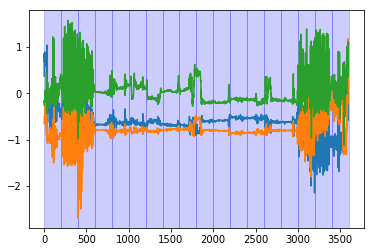

time: 175 ms


In [276]:
# This only plots the first sensor
X_dev_plot = X_dev if len(X_dev.shape) <= 3 else X_dev[:,:,0]

MtbVisualizer.plot_results(X_dev_plot, y_pred_dev, SAMPLE_SIZE)

### Actual results

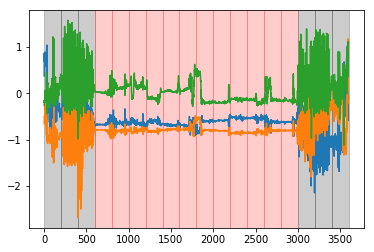

time: 177 ms


In [277]:
MtbVisualizer.plot_results(X_dev_plot, y_dev, SAMPLE_SIZE)

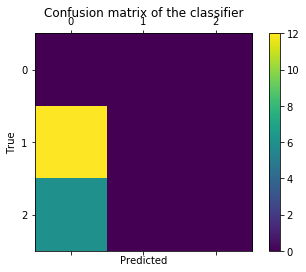

time: 151 ms


In [278]:
MtbVisualizer.print_confusion_matrix(y_dev, y_pred_dev)

### Test on Train data

In [279]:
#y_pred_train = model_cnn1.predict(X_train)
y_pred_train = model_cnn2.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=1)

time: 15.4 ms


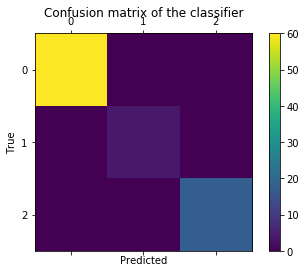

time: 150 ms


In [280]:
MtbVisualizer.print_confusion_matrix(y_train, y_pred_train)

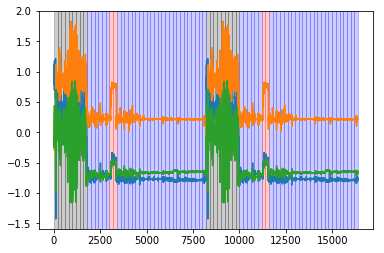

time: 300 ms


In [281]:
# This only plots the first sensor
X_train_plot = X_train if len(X_train.shape) <= 3 else X_train[:,:,0]

MtbVisualizer.plot_results(X_train_plot, y_pred_train, SAMPLE_SIZE)

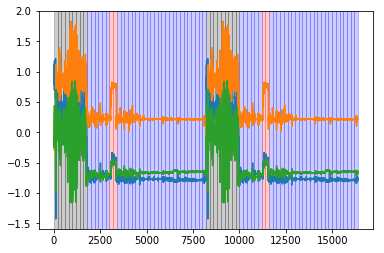

time: 294 ms


In [282]:
MtbVisualizer.plot_results(X_train_plot, y_train, SAMPLE_SIZE)